In [6]:
import torch
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet18(nn.Module):
    
    def __init__(self, num_classes=3):
        def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
            blk = []
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(Residual(input_channels, num_channels,
                       use_1x1conv=True, strides=2))
                else:
                    blk.append(Residual(num_channels, num_channels))
            return blk
        super(ResNet18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                   )
        self.layer1 = nn.Sequential(*resnet_block(64, 64, 2, True))
        self.layer2 = nn.Sequential(*resnet_block(64, 128, 2))
        self.layer3 = nn.Sequential(*resnet_block(128, 256, 2))        
        self.layer4 = nn.Sequential(*resnet_block(256, 512, 2))        
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


['melted_snow', 'water', 'wet']
ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

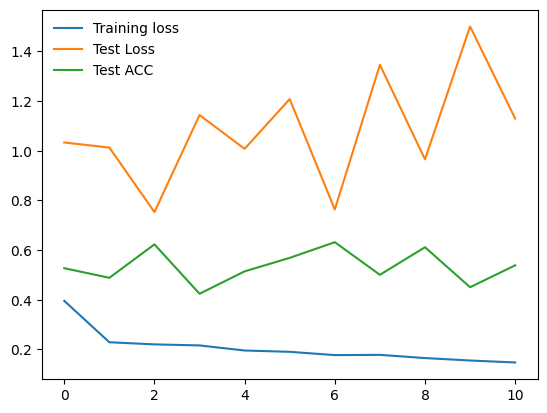

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

#set hyperparameter
EPOCH = 3
BATCH_SIZE = 64
LR = 0.15
data_dir = "./data/basic_data/"
def load_split_train_test(datadir,valid_size = 0.2):
    train_trainsforms = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),])
    test_trainsforms = transforms.Compose([transforms.Resize((224,224)),
                                           transforms.ToTensor(),])
    verify_trainsforms = transforms.Compose([transforms.Resize((224,224)),
                                           transforms.ToTensor(),])

    train_data = datasets.ImageFolder(datadir,transform=train_trainsforms)
    test_data = datasets.ImageFolder(datadir,transform=test_trainsforms)
    verify_data = datasets.ImageFolder(datadir,transform=verify_trainsforms)

    
    num_train = len(train_data)  # 训练集数量
    indices = list(range(num_train))
    np.random.shuffle(indices)  # 基于训练集索引打乱数据集
    
    # 拆分：取100个验证集，分出20%数据作为测试集
    split = 100 + int(np.floor(valid_size * (num_train - 100)))
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[100:split]
    verify_idx = indices[:100]  #
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler  = SubsetRandomSampler(test_idx)
    verify_sampler = SubsetRandomSampler(verify_idx)
    
    train_loader = DataLoader(train_data,sampler=train_sampler,batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_data,sampler=test_sampler,batch_size=BATCH_SIZE)
    verify_loader = DataLoader(verify_data, sampler=verify_sampler,batch_size=100, num_workers=4)
    return train_loader,test_loader,verify_loader

train_loader,test_loader,verify_loader = load_split_train_test(data_dir, 0.2)
print(train_loader.dataset.classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 就是CPU
model = ResNet18()
# for param in model.parameters():
#     param.requires_grad = False
print(model)

criterion = nn.CrossEntropyLoss()
net = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)

steps = 0
running_loss = 0
train_losses, test_losses, test_acc = [], [], []

for epoch in range(EPOCH):
    for inputs,labels in train_loader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        steps += 1
        # 因为按epoch打印间隔过长（性能不足），每32轮打印一下准确度
        if (steps + 1) % 32 == 0:
            test_loss = 0
            accuracy = 0
            net.eval()
            
            for inputs,labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                out2 = net(inputs)
                batch_loss = criterion(out2,labels)
                test_loss +=batch_loss.item()
                
                ps = torch.exp(out2)
                top_pred,top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            test_acc.append(accuracy/len(test_loader))

            print(f"Epoch {epoch+1}/{EPOCH}"
              f"Train loss: {running_loss/5:.3f}",
              f"Test loss: {test_loss/len(test_loader):.3f} "
              f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            net.train()
torch.save(model,"./pytorch_Image_Training.pth")

plt.plot(train_losses,label = "Training loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(test_acc, label='Test ACC')
plt.legend(frameon=False)
plt.show()


classes: ['melted_snow', 'water', 'wet']


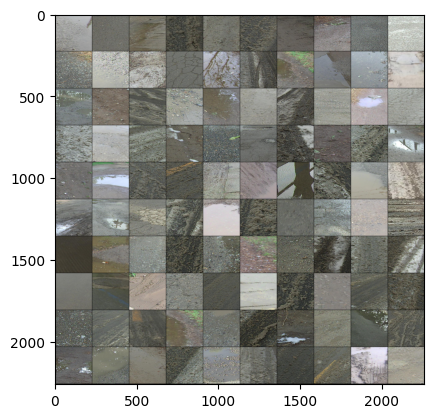

GroundTruth: 
 water   wet water melted_snow   wet melted_snow   wet   wet   wet   wet   wet water   wet   wet water melted_snow water water water water water   wet melted_snow water water water melted_snow   wet water   wet melted_snow   wet melted_snow   wet   wet   wet melted_snow   wet melted_snow water   wet water melted_snow melted_snow   wet water water melted_snow water melted_snow water water   wet melted_snow water melted_snow   wet   wet water melted_snow   wet water   wet melted_snow water   wet   wet melted_snow melted_snow melted_snow water water water   wet melted_snow   wet melted_snow   wet melted_snow melted_snow   wet melted_snow melted_snow water   wet melted_snow   wet   wet water melted_snow water water water melted_snow water melted_snow melted_snow melted_snow water   wet
Predicted: 
 water   wet water melted_snow   wet melted_snow water   wet   wet water   wet water   wet   wet   wet melted_snow water   wet water water   wet   wet melted_snow   wet water water 

In [25]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision

import numpy as np
import matplotlib.pyplot as plt

def loadtestdata(img_path,num):
    testset = datasets.ImageFolder(img_path,
                                   transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor()]))
    testloader = DataLoader(testset, batch_size=num,shuffle=True, num_workers=4)

    dataiter = iter(testloader)
    images,labels = dataiter.next()
    classes = testloader.dataset.classes
    print("classes:",classes)
    return images,labels,classes

def loadVerifyData():
    dataiter = iter(verify_loader)
    images,labels = dataiter.next()
    classes = verify_loader.dataset.classes
    print("classes:",classes)
    return images,labels,classes

def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


def test(model_path,img_path,num, verify=False):
    hit = 0
    net = torch.load(model_path)
    if not verify:
        images, labels, classes = loadtestdata(img_path,num)
    else:
        images, labels, classes = loadVerifyData()
    
    # 上面为了编码方便，verify_loader的BATCH_SIZE=100写死了，匹配这里的num.
    #  num = max(num, len(images))
    imshow(torchvision.utils.make_grid(images, nrow=10)) # nrow是每行显示的图片数量，缺省值为8
    print('GroundTruth: \n', " ".join('%5s' % classes[labels[j]] for j in range(num)))  # 打印（test集里图片的标签）

    outputs = net(Variable(images.cpu()))
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: \n', " ".join('%5s' % classes[predicted[j]] for j in range(num)))
    
    for j in range(num):
        if classes[labels[j]] == classes[predicted[j]]:
            hit = hit + 1
    print("ACC:", hit, "/", num)

test(model_path='./pytorch_Image_Training.pth', img_path="./data/basic_data/", num=100, verify=True)
# test(model_path='./pytorch_Image_Training.pth', img_path="./data/basic_data/", num=100)
# test(model_path='./archive-pth/pytorch_Image_Training-LR0.1-Batch10.pth', img_path="./data/basic_data/", num=100)

In [39]:
from torch.autograd import Variable
from torchvision import transforms
import os
import shutil
from PIL import Image


def get_img(image_path):
    img_list = []
    for i in os.listdir(image_path):
        img_list.append(image_path+"/"+i)
    img_list.sort() # 这行是必要的！！因为listdir没有按序，需要按文件名排序
    return img_list

def load_models():
    model = torch.load('./archive-pth/0.84pytorch_Image_Training-LR0.1-Batch10.pth')
    # model = torch.load('./pytorch_Image_Training.pth')
    model.eval()
    return model

def predict_image(image_path):
    image = Image.open(image_path)

    transformation = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),])

    image_tensor = transformation(image)
    image_tensor = image_tensor.unsqueeze_(0) # 预处理图像, 额外添加一个批次维度，因为PyTorch将所有的图像当做批次

    model = load_models()

    input = Variable(image_tensor.cpu())  # 将输入变为变量
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


image_path = r'./data/pred_data/'
img_list = get_img(image_path)
for i in img_list:
    index = predict_image(i)
    # origin classes: 
    id2tag = {0:'melted_snow',1: 'water',2: 'wet'}
    # print(f"{i=} {id2tag[index]}" )
    tag2res = {'melted_snow': 1, 'water': 0, 'wet': 2}
    print(tag2res[id2tag[index]])
    target = './ans/'+id2tag[index]
    if os.path.exists(target):
        shutil.copy(i, target)
    else:
        os.mkdir(target)
        shutil.copy(i, target)

2
0
1
0
0
0
1
0
0
0
0
1
0
1
1
0
2
0
0
0
0
1
0
0
0
1
2
2
0
1
2
1
2
1
2
0
0
0
1
2
1
0
1
2
0
1
0
2
2
1
2
1
0
1
0
1
2
2
0
2
2
0
1
1
0
2
0
1
1
0
2
0
2
1
2
0
1
0
2
1
0
1
0
2
1
0
1
0
0
2
0
2
1
2
0
0
2
2
1
1


In [41]:
def predict_image(image_path):
    image = Image.open(image_path)

    transformation = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),])

    image_tensor = transformation(image)  # 预处理图像
    image_tensor = image_tensor.unsqueeze_(0)    # 额外添加一个批次维度，因为PyTorch将所有的图像当做批次

    model = load_models()

    input = Variable(image_tensor.cpu())   # 将输入变为变量
    output = model(input)                   # 预测图像的类
    index = output.data.cpu().numpy().argmax()
    return index

idx = predict_image("./data/basic_data/wet/202201262358206-wet-concrete-smooth.jpg")
id2tag = {0:'melted_snow',1: 'water',2: 'wet'}
tag2res = {'melted_snow': 1, 'water': 0, 'wet': 2}
print(id2tag[idx])

wet
